In [129]:
import jax.numpy as jnp
from ddfa_node import sample_floquet_multipliers, backtrace_multipliers
import matplotlib.pyplot as plt

# load reload extension:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
generated_data = jnp.load("outputs/gen_data_vdp.npy")
print(generated_data.shape)

(100, 2000, 4)


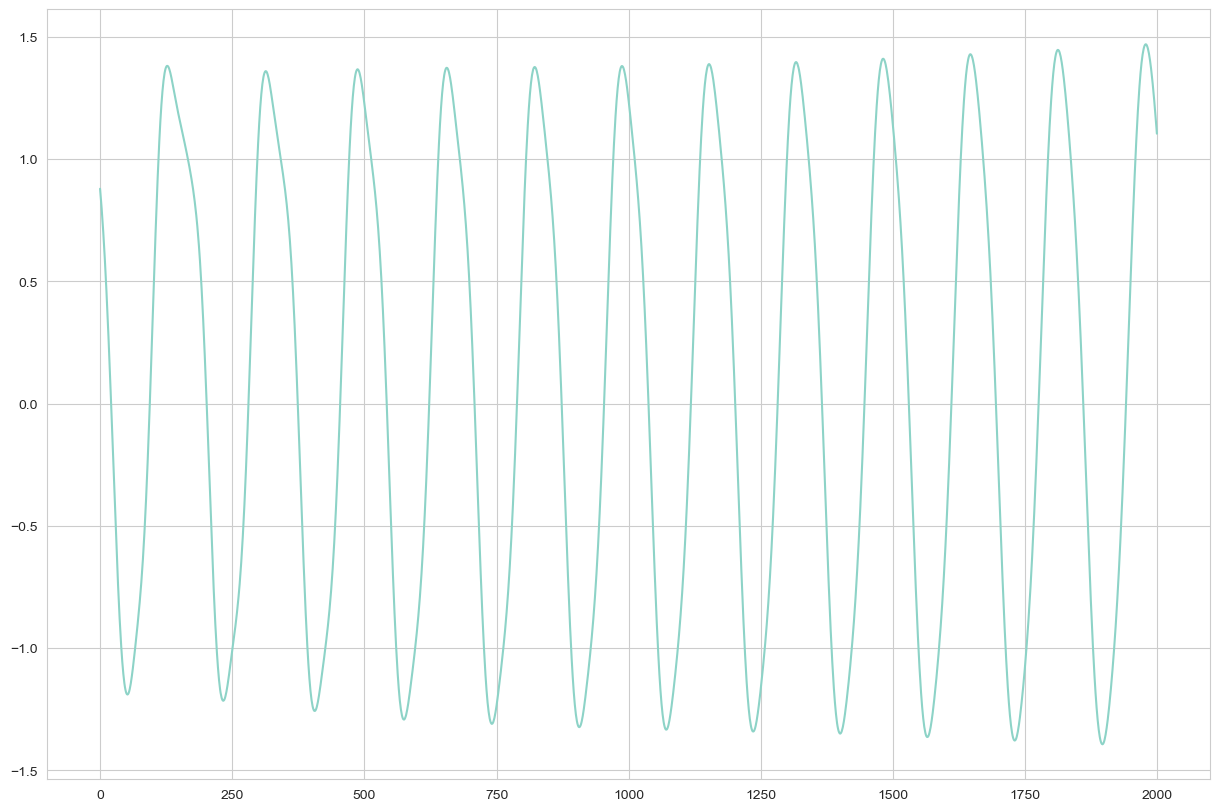

In [127]:
plt.plot(generated_data[0, :, 0])


In [130]:
allEigenvals, allEigenvecs, allRs, allPhis, Ns = sample_floquet_multipliers(
    generated_data,
    nSegments=101, 
    nCovReps=1, 
    phaser_feats=None, 
    splits=range(2, 5), 
    nReplicates=300, 
    usePCA=False, 
    height=0.85, 
    distance=100, 
    vecs=False)

  0%|          | 0/100 [00:00<?, ?it/s]/home/michael/Synology/Desktop/Data/Python/NeuralODE/.pixi/envs/default/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/home/michael/Synology/Desktop/Data/Python/NeuralODE/.pixi/envs/default/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/home/michael/Synology/Desktop/Data/Python/NeuralODE/.pixi/envs/default/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/michael/Synology/Desktop/Data/Python/NeuralODE/.pixi/envs/default/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  r

KeyboardInterrupt: 

In [ ]:
backtrace_multipliers(splits, eigVals, Ns, subject=0, nPoints=5, phase=50, eig=0, plot=True, plot_title=None, ax=None)